**Natal - RN**

In [1]:
# Importando módulos internos
import geocov19_functions_results as fresults

# Importando módulos externos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statistics import mean
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [3]:
city = 'Natal'
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'city':city, 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [4]:
len(df)

14674

In [5]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 11:21:01,place,Rio Grande do Norte,Natal,Fui tentar repercutir a pesquisa do @oatila na...,-0.2498,pt
1,2020-02-02 13:22:30,user_location,Rio Grande do Norte,Natal,NOVA NATAL NEWS: Coronavírus: deputada pede ur...,0.0000,pt
2,2020-02-02 13:34:31,user_location,Rio Grande do Norte,Natal,"RT @dailyselenabr: O Site ""South China morning...",0.5423,pt
3,2020-02-02 13:37:08,user_location,Rio Grande do Norte,Natal,@LuizXavier25 Deve ser bem o coronavirus kkkk,0.0000,pt
4,2020-02-02 13:39:10,user_location,Rio Grande do Norte,Natal,Brasil registra 16 casos suspeitos de coronavi...,-0.2263,pt


Média total de sentimentos - Vader

In [6]:
df['score'].describe()

count    14674.000000
mean        -0.061176
std          0.431359
min         -0.997100
25%         -0.400500
50%          0.000000
75%          0.202300
max          0.997500
Name: score, dtype: float64

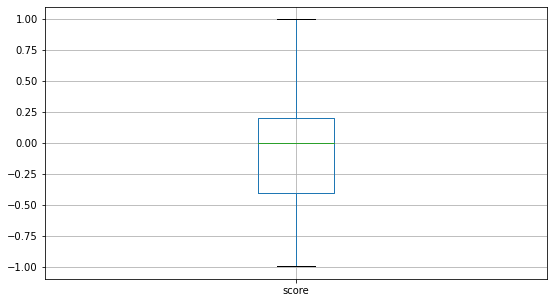

In [7]:
boxplot = df.boxplot(column=['score'], grid=True, figsize=(9, 5))

Média de sentimentos por dia - Vader x SenticNet

Análises por período

In [45]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [46]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "'+city+'"')
df_cases_city = df_cases_city.reset_index()
df_cases_city = df_cases_city.drop(columns=['index'])
df_cases_city.head()

,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,Natal,2020-03-12,1,0.1123,0.0,0,RN,1,0
1,Natal,2020-03-13,1,0.1123,0.0,0,RN,0,0
2,Natal,2020-03-14,1,0.1123,0.0,0,RN,0,0
3,Natal,2020-03-15,1,0.1123,0.0,0,RN,0,0
4,Natal,2020-03-16,1,0.1123,0.0,0,RN,0,0


In [47]:
# Data do início das medidas restritivas
restriction_date = '2020-03-17'
print(restriction_date)

2020-03-17


In [48]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-03-12


In [49]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

2020-04-01


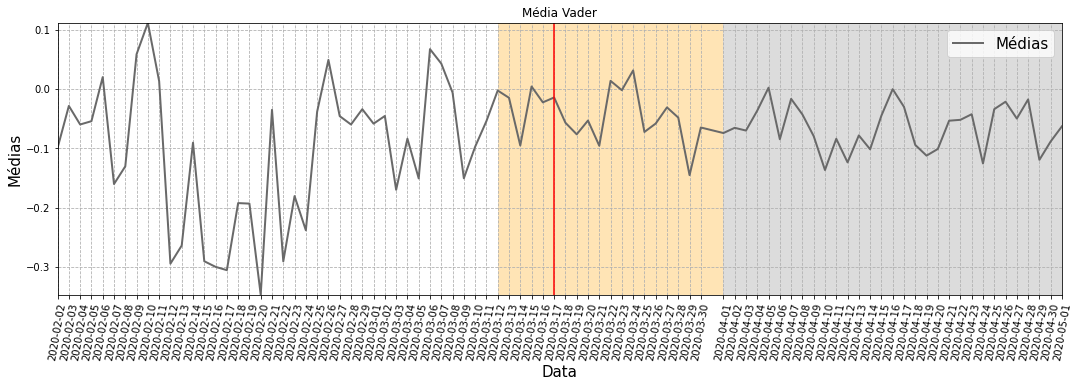

In [50]:
df_scores_city = fresults.building_dates_df(df, 'score')

x = df_scores_city.created_at
y = df_scores_city.score_mean

color = 'dimgrey'

label = 'Médias'
xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader'

fresults.generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, restriction_date, first_case_date, first_death_date)

**Análises por Período - Geral**

In [51]:
df_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case_date+' 00:00:00"')
print(len(df_periodo1))

df_periodo2 = df.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
print(len(df_periodo2))

df_periodo3 = df.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
print(len(df_periodo3))

1140
3310
10224


In [52]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

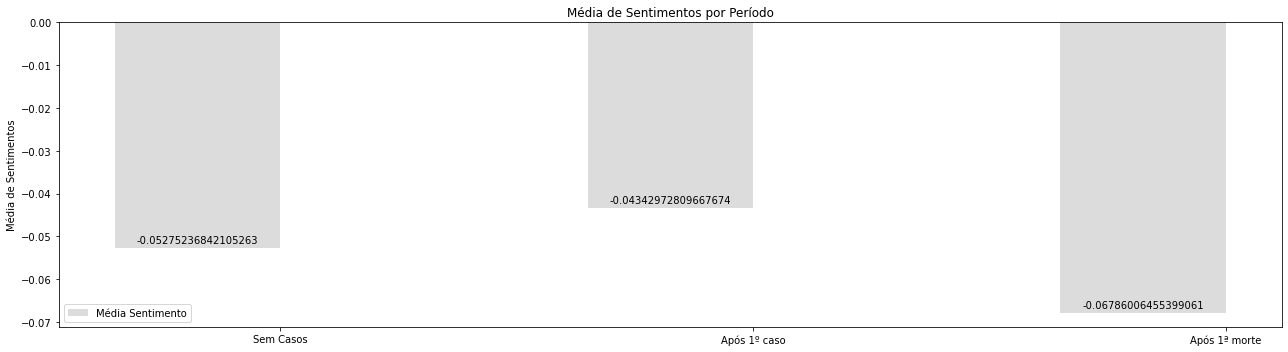

In [53]:
labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df_periodo1['score']), mean(df_periodo2['score']), mean(df_periodo3['score'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()

***
**Análises por Período - Detalhado**

**Tweets Negativos**

In [54]:
start = df['score'].describe()['min']
end = df['score'].describe()['25%']

print(start,end)

-0.9971 -0.4005


Nuvem de palavras dos tweets mais negativos

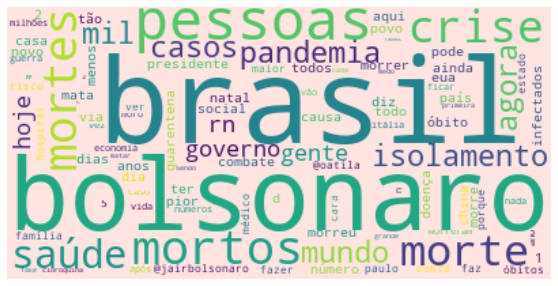

In [55]:
tokens_neg = fresults.return_tokens_from_interval(df, start, end)
fresults.generate_cloud_from_tokens(tokens_neg, 'mistyrose')

Palavras presentes nos tweets que mais influenciaram negativamente

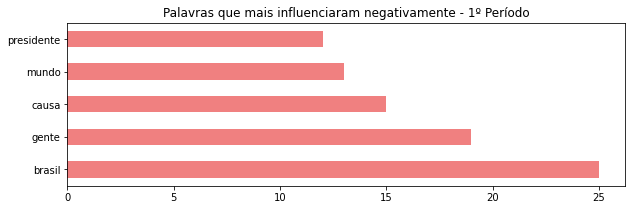

In [56]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
tokens_neg_1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
fresults.generate_bar_from_tokens(tokens_neg_1, 5, 'lightcoral', 10, 3, title)

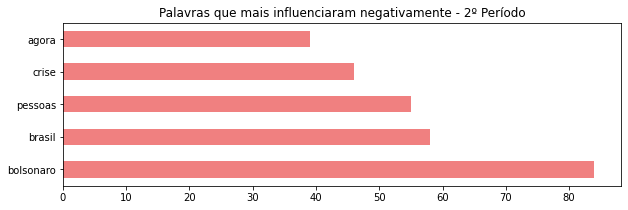

In [57]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
tokens_neg_2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
fresults.generate_bar_from_tokens(tokens_neg_2, 5, 'lightcoral', 10, 3, title)

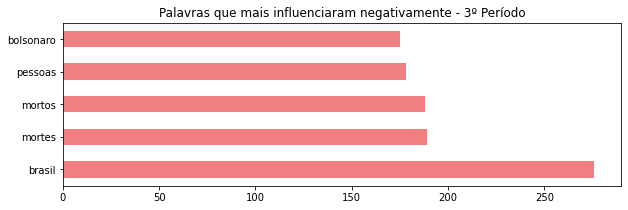

In [58]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
tokens_neg_3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
fresults.generate_bar_from_tokens(tokens_neg_3, 5, 'lightcoral', 10, 3, title)

Hashtags que mais influenciaram negativamente

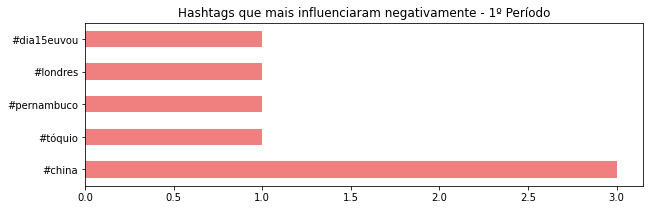

In [59]:
title = 'Hashtags que mais influenciaram negativamente - 1º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_1, 5, '#', 'lightcoral', 10, 3, title)

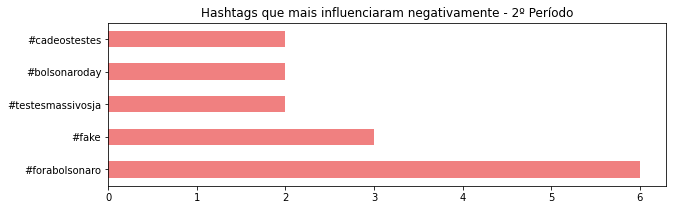

In [60]:
title = 'Hashtags que mais influenciaram negativamente - 2º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_2, 5, '#', 'lightcoral', 10, 3, title)

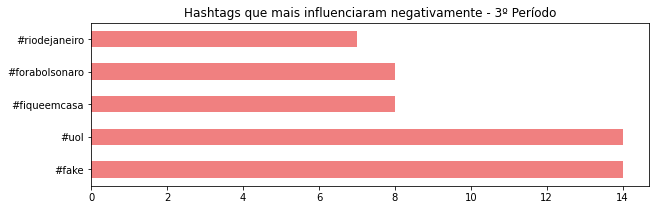

In [61]:
title = 'Hashtags que mais influenciaram negativamente - 3º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_3, 5, '#', 'lightcoral', 10, 3, title)

**Tweets Positivos**

In [62]:
start = df['score'].describe()['75%']
end = df['score'].describe()['max']

print(start,end)

0.2023 0.9975


Nuvens de palavras que influenciaram positivamente

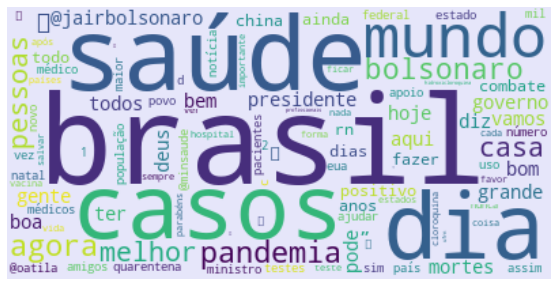

In [63]:
tokens_pos = fresults.return_tokens_from_interval(df, start, end)
fresults.generate_cloud_from_tokens(tokens_pos, 'lavender')

Palavras presentes nos tweets que mais influenciaram positivamente

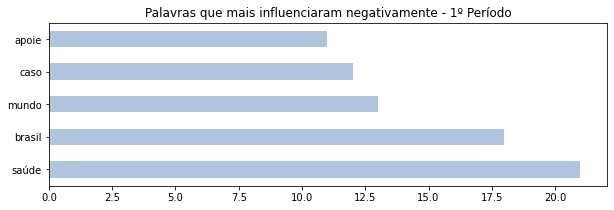

In [64]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
tokens_pos_1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
fresults.generate_bar_from_tokens(tokens_pos_1, 5, 'lightsteelblue', 10, 3, title)

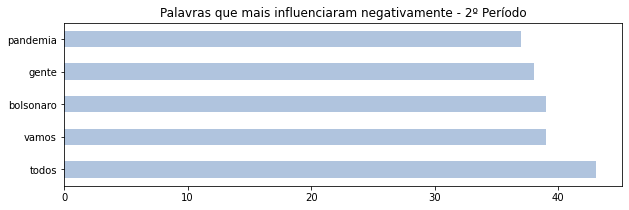

In [65]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
tokens_pos_2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
fresults.generate_bar_from_tokens(tokens_pos_2, 5, 'lightsteelblue', 10, 3, title)

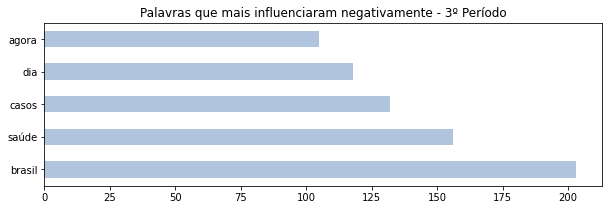

In [66]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
tokens_pos_3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
fresults.generate_bar_from_tokens(tokens_pos_3, 5, 'lightsteelblue', 10, 3, title)

Hashtags que mais influenciaram positivamente

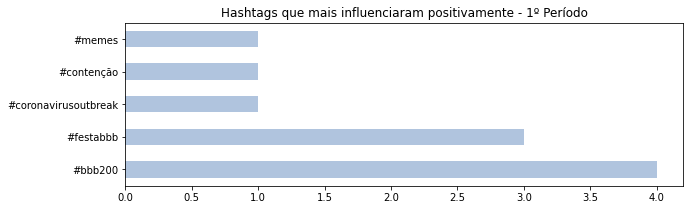

In [67]:
title = 'Hashtags que mais influenciaram positivamente - 1º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_1, 5, '#', 'lightsteelblue', 10, 3, title)

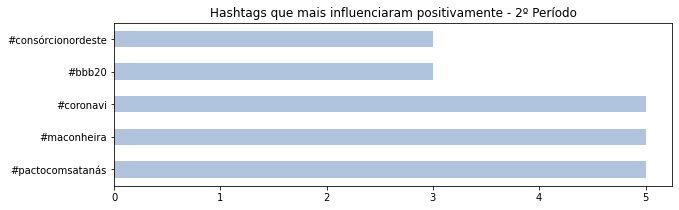

In [68]:
title = 'Hashtags que mais influenciaram positivamente - 2º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_2, 5, '#', 'lightsteelblue', 10, 3, title)

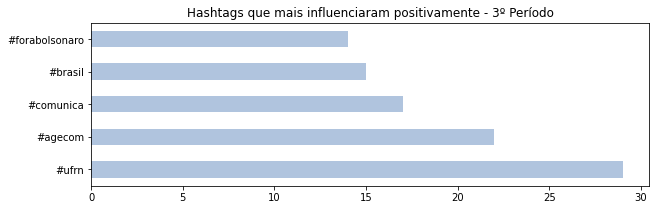

In [69]:
title = 'Hashtags que mais influenciaram positivamente - 3º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_3, 5, '#', 'lightsteelblue', 10, 3, title)

***
Correlações com Casos de Covid

In [70]:
df_cases_city_2 = df_cases_city.query('date >= "'+first_case_date+'" and date < "'+first_death_date+'"')
df_cases_city_3 = df_cases_city.query('date >= "'+first_death_date+'" and date < "2020-05-02"')

df_scores_city_2 = df_scores_city.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
df_scores_city_3 = df_scores_city.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')

df_prepared_2 = fresults.prepare_data(df_cases_city_2, df_scores_city_2)
df_prepared_3 = fresults.prepare_data(df_cases_city_3, df_scores_city_3)

In [71]:
target_column = 'score_mean'
corr_matrix = df_prepared_2.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean           1.000000
bad_news_pct         0.308189
new_confirmed_pct    0.308189
bad_news            -0.006125
new_confirmed       -0.006125
Name: score_mean, dtype: float64

In [72]:
target_column = 'score_mean'
corr_matrix = df_prepared_3.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean           1.000000
new_deaths_pct       0.448806
bad_news_pct         0.359913
new_confirmed_pct    0.339624
last_bad_news_pct    0.330300
Name: score_mean, dtype: float64

***
Correlações de tweets negativos com casos de Covid

In [82]:
# Selecionado somentes tweets mais negativos do período
start = df_periodo2['score'].describe()['min']
end = df_periodo2['score'].describe()['25%']

df_periodo2_neg = df_periodo2.loc[(df_periodo2['score'] > start) & (df_periodo2['score'] < end)]
df_scores_city_neg_2 = fresults.building_dates_df(df_periodo2_neg, 'score')

In [83]:
# Selecionado somentes tweets mais negativos do período
start = df_periodo3['score'].describe()['min']
end = df_periodo3['score'].describe()['25%']

df_periodo3_neg = df_periodo3.loc[(df_periodo3['score'] > start) & (df_periodo3['score'] < end)]
df_scores_city_neg_3 = fresults.building_dates_df(df_periodo3_neg, 'score')

In [84]:
df_scores_city_2 = df_scores_city_neg_2.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
df_scores_city_3 = df_scores_city_neg_3.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')

df_prepared_2 = fresults.prepare_data(df_cases_city_2, df_scores_city_2)
df_prepared_3 = fresults.prepare_data(df_cases_city_3, df_scores_city_3)

In [85]:
target_column = 'score_mean'
corr_matrix = df_prepared_2.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean           1.000000
bad_news_pct         0.104468
new_confirmed_pct    0.104468
bad_news            -0.026506
new_confirmed       -0.026506
Name: score_mean, dtype: float64

In [86]:
target_column = 'score_mean'
corr_matrix = df_prepared_3.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                   1.000000
last_available_deaths_pct    0.333960
bad_news                     0.296639
new_confirmed                0.294975
last_bad_news_pct            0.259952
Name: score_mean, dtype: float64